Num quarter files: 7
First 10: ['data1_2023_Q1.parquet', 'data1_2023_Q3.parquet', 'data1_2023_Q4.parquet', 'data1_2024_Q2.parquet', 'data1_2024_Q4.parquet', 'data1_2025_Q1.parquet', 'data1_2025_Q2.parquet']


,gross_SR,net_SR,gross_CR,net_CR,gross_cumPnL,net_cumPnL,avg_daily_trades,total_trades,num_days,summary_stat
label,,,,,,,,,,
2023_Q1,2.453375,2.227702,7.610103,6.457615,15663.15,14211.15,1.375000,121.0,88,4.585367
2023_Q3,-1.343959,-1.654853,-2.551613,-2.836592,-5338.05,-6634.05,1.213483,108.0,89,-4.077446
2023_Q4,0.717685,0.393982,2.199909,1.102072,2618.60,1442.60,1.101124,98.0,89,-0.038850
2024_Q2,1.870274,1.619708,7.174608,5.723990,9054.60,7854.60,1.123596,100.0,89,2.307829
2024_Q4,-0.064478,-0.283145,-0.151763,-0.613886,-381.45,-1677.45,1.173913,108.0,92,-0.405101
2025_Q1,-0.904766,-1.136053,-1.284419,-1.463568,-5185.90,-6541.90,1.269663,113.0,89,-3.072880
2025_Q2,1.516462,1.429531,3.714399,3.440365,18192.40,17148.40,0.956044,87.0,91,2.641639


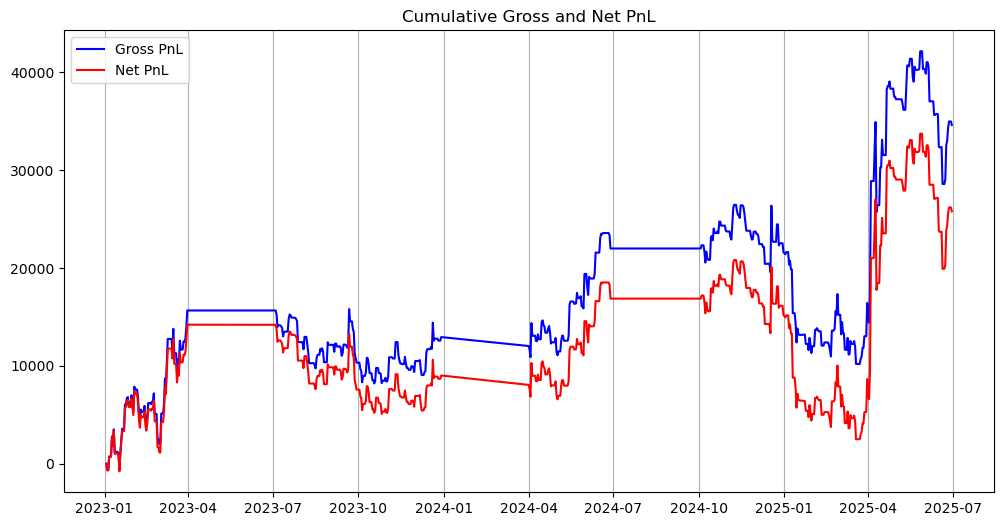

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re

CONTRACTS = {
    "SP":  {"cost": 12, "point_value": 50},
    "NQ":  {"cost": 12, "point_value": 20},
}

GROUP1_ASSETS = ["SP", "NQ"]

GROUP1_RULES = {
    "session_start": "09:30",
    "session_end": "16:00",
    "no_trade_start": "09:31",
    "no_trade_end": "09:55",
    "force_exit": "15:40",
    "drop_early_start": "09:31",
    "drop_early_end": "09:40",
    "drop_late_start": "15:51",
    "drop_late_end": "16:00",
}

ANNUALIZATION_DAYS = 252

def load_data(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)

    if not isinstance(df.index, pd.DatetimeIndex):
        datetime_col = None
        for col in df.columns:
            c = col.lower()
            if "datetime" in c or "time" in c or "date" in c:
                datetime_col = col
                break

        if datetime_col is not None:
            df[datetime_col] = pd.to_datetime(df[datetime_col])
            df = df.set_index(datetime_col)

    return df.sort_index()

def time_between(index: pd.DatetimeIndex, start: str, end: str):
    t = index.time
    start_t = pd.to_datetime(start).time()
    end_t = pd.to_datetime(end).time()
    return (t >= start_t) & (t <= end_t)


def group1_masks(df: pd.DataFrame):
    idx = df.index
    masks = {}

    masks["in_session"] = time_between(idx, GROUP1_RULES["session_start"], GROUP1_RULES["session_end"])
    masks["no_trade"] = time_between(idx, GROUP1_RULES["no_trade_start"], GROUP1_RULES["no_trade_end"])
    masks["force_exit"] = time_between(idx, GROUP1_RULES["force_exit"], GROUP1_RULES["session_end"])

    masks["drop_calc"] = (
        time_between(idx, GROUP1_RULES["drop_early_start"], GROUP1_RULES["drop_early_end"])
        | time_between(idx, GROUP1_RULES["drop_late_start"], GROUP1_RULES["drop_late_end"])
    )

    return masks      

PROJECT_ROOT = Path.cwd().resolve().parents[0]   # notebooks/ -> project root
G1_TRADE_DIR = PROJECT_ROOT / "data_processed" / "group1" / "trade"

files = sorted(G1_TRADE_DIR.glob("*.parquet"))
print("Num quarter files:", len(files))
print("First 10:", [f.name for f in files[:10]])

pat = re.compile(r"(\d{4})_Q([1-4])")
quarters = []
for f in files:
    m = pat.search(f.name)
    if m:
        year = int(m.group(1))
        q = int(m.group(2))
        quarters.append({"file": str(f), "year": year, "quarter": q, "label": f"{year}_Q{q}"})

quarter_df = pd.DataFrame(quarters).sort_values(["year","quarter"]).reset_index(drop=True)

def annualized_sharpe(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    vol = x.std(ddof=0)
    if vol == 0:
        return np.nan
    return (x.mean() / vol) * np.sqrt(TRADING_DAYS)

def calmar_ratio(pnl_daily, freq=252):
    if pnl_daily.std() == 0:
        return np.nan

    # cumulative PnL
    cum = pnl_daily.cumsum()

    # drawdown
    running_max = cum.cummax()
    drawdown = cum - running_max
    max_dd = drawdown.min()

    if max_dd == 0:
        return np.nan

    annual_return = pnl_daily.mean() * freq
    return annual_return / abs(max_dd)

ASSET = "SP"
POINT_VALUE = 50
TCOST_PER_TRADE = 12
TRADING_DAYS = 252

# EMA settings
EMA_FAST = 20
EMA_SLOW = 240

def run_ema_crossover(
    df: pd.DataFrame,
    asset: str = "SP",
    ema_fast: int = 20,
    ema_slow: int = 240,
    vol_win: int = 120,
    k_enter: float = 10,
    k_exit: float = 5,
    point_value: float = 50.0,
    tcost_per_trade: float = 12.0,
) -> dict:
    """
    EMA(ema_fast)-EMA(ema_slow) trend-following with volatility-scaled strength bands.
    - strength = |ema_fast - ema_slow| / price
    - vol      = rolling std of returns
    - enter when strength >= k_enter * vol (and direction != 0)
    - exit  when strength <= k_exit  * vol OR direction flips
    Returns daily gross/net PnL in USD and trade counts.
    """

    # --- Price series ---
    price = df[asset].astype(float).dropna().sort_index()
    if len(price) < max(ema_slow, vol_win) + 5:
        # Not enough data to compute indicators reliably
        empty = pd.Series(dtype=float)
        return {
            "pnl_daily_gross_usd": empty,
            "pnl_daily_net_usd": empty,
            "trades_daily": empty,
            "pos": pd.Series(dtype=int),
        }

    # --- EMAs ---
    ema_f = price.ewm(span=ema_fast, adjust=False).mean()
    ema_s = price.ewm(span=ema_slow, adjust=False).mean()

    # Direction: +1 if fast>slow, -1 if fast<slow, 0 if equal (rare)
    dir_raw = np.sign(ema_f - ema_s)
    dir_raw = pd.Series(dir_raw, index=price.index).replace(0, np.nan).ffill().fillna(0).astype(int)

    # --- Strength (normalized by price) ---
    strength = (ema_f - ema_s).abs() / price

    # --- Volatility band (same scale as strength, since vol is std of returns) ---
    ret = price.pct_change()
    vol = ret.rolling(vol_win).std()

    enter_band = (k_enter * vol)
    exit_band  = (k_exit  * vol)

    # Block trading until vol exists (avoid NaNs)
    enter_band = enter_band.fillna(np.inf)   # cannot enter before vol is defined
    exit_band  = exit_band.fillna(-np.inf)   # cannot exit by band before vol is defined

    # --- Persistent position with hysteresis ---
    pos = pd.Series(0, index=price.index, dtype=int)
    state = 0  # 0 flat, +1 long, -1 short

    for i in range(1, len(pos)):
        d = int(dir_raw.iat[i])          # desired direction from EMA cross
        s = float(strength.iat[i])       # normalized strength
        eb_enter = float(enter_band.iat[i])
        eb_exit  = float(exit_band.iat[i])

        if state == 0:
            # Enter only if direction exists and strength exceeds enter band
            if d != 0 and s >= eb_enter:
                state = d

        elif state == 1:
            # Exit long if strength weakens below exit band OR direction flips to short
            if (s <= eb_exit) or (d == -1):
                state = 0

        elif state == -1:
            # Exit short if strength weakens below exit band OR direction flips to long
            if (s <= eb_exit) or (d == 1):
                state = 0

        pos.iat[i] = state

    # --- PnL in points (avoid look-ahead: use previous bar position) ---
    dp = price.diff()
    pos_lag = pos.shift(1).fillna(0).astype(int)
    pnl_points = (pos_lag * dp).rename("pnl_points")

    # --- Daily aggregation ---
    pnl_daily_points = pnl_points.resample("1D").sum().rename("pnl_daily_points")

    # --- Trades: count position changes (each change = one transaction) ---
    trades_1m = pos.diff().abs().fillna(0)
    trades_daily = trades_1m.resample("1D").sum().rename("trades_daily")

    # --- USD PnL ---
    pnl_daily_gross_usd = (pnl_daily_points * point_value).rename("pnl_daily_gross_usd")
    cost_daily_usd = (trades_daily * tcost_per_trade).rename("cost_daily_usd")
    pnl_daily_net_usd = (pnl_daily_gross_usd - cost_daily_usd).rename("pnl_daily_net_usd")

    return {
        "pnl_daily_gross_usd": pnl_daily_gross_usd,
        "pnl_daily_net_usd": pnl_daily_net_usd,
        "trades_daily": trades_daily,
        "pos": pos,
        "strength": strength,
        "vol": vol,
        "enter_band": enter_band,
        "exit_band": exit_band,
    }

results = []
outs = {} 

for _, row in quarter_df.iterrows():
    label = row["label"]
    df_q = pd.read_parquet(row["file"])

    out = run_ema_crossover(
        df_q,
        asset=ASSET,
        ema_fast=EMA_FAST,
        ema_slow=EMA_SLOW,
        point_value=POINT_VALUE,
        tcost_per_trade=TCOST_PER_TRADE
    )

    # Use daily series for metrics
    g = out["pnl_daily_gross_usd"].dropna()
    n = out["pnl_daily_net_usd"].dropna()
    td = out["trades_daily"].dropna()

    results.append({
        "label": label,

        # Sharpe ratios (daily)
        "gross_SR": annualized_sharpe(g),
        "net_SR": annualized_sharpe(n),
        # Calmar ratio 
        "label": label,

        "gross_SR": annualized_sharpe(g),
        "net_SR": annualized_sharpe(n),

        "gross_CR": calmar_ratio(g),
        "net_CR": calmar_ratio(n),

        "gross_cumPnL": float(g.sum()),
        "net_cumPnL": float(n.sum()),

        "avg_daily_trades": float(td.mean()) if len(td) else np.nan,
        "total_trades": float(td.sum()) if len(td) else np.nan,
        "num_days": int(n.count()),

        # Cumulative PnL (sum of daily USD)
        "gross_cumPnL": float(g.sum()),
        "net_cumPnL": float(n.sum()),

        # Trading activity
        "avg_daily_trades": float(td.mean()) if len(td) else np.nan,
        "total_trades": float(td.sum()) if len(td) else np.nan,

        # Sample size
        "num_days": int(n.count()),
    })

    outs[label] = out

perf_df = pd.DataFrame(results).set_index("label").sort_index()

# Collect daily series across quarters
net_all = pd.concat([outs[k]["pnl_daily_net_usd"] for k in outs]).sort_index()
gross_all = pd.concat([outs[k]["pnl_daily_gross_usd"] for k in outs]).sort_index()
trades_all = pd.concat([outs[k]["trades_daily"] for k in outs]).sort_index()

summary_all = pd.Series({
    "gross_SR": annualized_sharpe(gross_all.dropna()),
    "net_SR": annualized_sharpe(net_all.dropna()),
    "gross_CR": calmar_ratio(gross_all.dropna()),
    "net_CR": calmar_ratio(net_all.dropna()),
    "gross_cumPnL": float(gross_all.dropna().sum()),
    "net_cumPnL": float(net_all.dropna().sum()),
    "avg_daily_trades": float(trades_all.dropna().mean()),
    "total_trades": float(trades_all.dropna().sum()),
    "num_days": int(net_all.dropna().count()),
})

def summary_stat(net_sr, net_pnl):
    return (net_sr - 0.5) * max(
        0.0,
        np.log(abs(net_pnl) / 1000.0)
    )

perf_df["summary_stat"] = perf_df.apply(
    lambda r: summary_stat(r["net_SR"], r["net_cumPnL"]),
    axis=1)


cols = [
    "gross_SR",
    "net_SR",
    "gross_CR",
    "net_CR",
    "gross_cumPnL",
    "net_cumPnL",
    "avg_daily_trades",
    "num_days",
    "summary_stat",
]
group1_csv = perf_df[cols].copy()
group1_csv = group1_csv.reset_index().rename(columns={"label": "quarter"})

total_score = perf_df["summary_stat"].sum() #1.94

group1_csv.to_csv(
    "group1_summary_statistics.csv",
    index=False
)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(gross_all.fillna(0)), label = 'Gross PnL', color='blue')
plt.plot(np.cumsum(net_all.fillna(0)), label = 'Net PnL', color='red')
plt.title('Cumulative Gross and Net PnL')
plt.legend()
plt.grid(axis='x')

plt.savefig(f"pnl.png", dpi = 300, bbox_inches = "tight")
perf_df

